In [ ]:
#!pip uninstall opencv-python

In [1]:
#!pip install -q -U "tensorflow-text==2.5.*"

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
gpu = gpus[0]

tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
import pandas as pd
import numpy as np
import datetime

import tensorflow_text as text
import tensorflow_hub as hub

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

from tensorboard.plugins.hparams import api as hp

In [233]:
#!python -m spacy download en_core_web_md -q

In [4]:
import spacy

In [5]:
from spacy.lang.en.stop_words import STOP_WORDS

In [6]:
import re

In [7]:
data = pd.read_csv('./spam.csv', encoding = 'ISO-8859-1')

In [8]:
data = data[['v1','v2']]

In [9]:
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
data['v2'][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [11]:
data['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [12]:
data['v2_clean'] = data['v2'].apply(lambda s : re.sub(r'[^\w\s]', '', s).lower())

In [13]:
data['v2_clean'] = data['v2_clean'].apply(lambda s : re.sub('[0-9]+', '', s))

In [14]:
data.head()

,v1,v2,v2_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [15]:
nlp = spacy.load('en_core_web_md')

In [16]:
data["v2_lemma"] = data["v2_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

In [17]:
data.head()

,v1,v2,v2_clean,v2_lemma
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...,free entry wkly comp win fa cup final tkts s...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah think usf live


In [18]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=2000, oov_token="out_of_vocab")
tokenizer.fit_on_texts(data['v2_lemma'])

In [19]:
vocab_size = tokenizer.num_words

In [20]:
data["v2_tokenized"] = tokenizer.texts_to_sequences(data['v2_lemma'])

In [67]:
data.head()

,v1,v2,v2_clean,v2_lemma,v2_tokenized
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...,"[1, 225, 433, 449, 905, 35, 50, 205, 744, 79, ..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni,"[10, 194, 1, 283, 2, 1382]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...,free entry wkly comp win fa cup final tkts s...,"[9, 295, 519, 639, 32, 1383, 745, 411, 1384, 1..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun early hor u c,"[2, 124, 150, 1, 2, 81]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah think usf live,"[684, 22, 640, 125]"


In [237]:
nb_val = int(len(data)*0.15)
data_val = data.sample(nb_val)
data_train = data.iloc[[i for i in data.index if i not in data_val.index],:]
print(f'Split of data..... train_data : {len(data_train)} - val_data : {len(data_val)}...')

Split of data..... train_data : 4737 - val_data : 835...


In [238]:
def data_under_sampling(data, nb_reduce):
  data_sample_2 = data.loc[data['v1']=='spam',:]
  len_class_sub = len(data_sample_2)
  data_sample_1 = data.loc[data['v1']=='ham',:].sample(nb_reduce * len_class_sub)
  
  return pd.concat([data_sample_1,data_sample_2], axis=0).sample(frac=1).reset_index(drop=True)


In [239]:
data_train['v1'].value_counts()

ham     4095
spam     642
Name: v1, dtype: int64

In [276]:
data_red = data_under_sampling(data_train, 5)

In [277]:
max_len_sentence = max([len(token) for token in data['v2_tokenized'].to_list()])

In [278]:
v2_pad_train = tf.keras.preprocessing.sequence.pad_sequences(data_red['v2_tokenized'], padding="post", maxlen=max_len_sentence)
v2_pad_val = tf.keras.preprocessing.sequence.pad_sequences(data_val['v2_tokenized'], padding="post", maxlen=max_len_sentence)

In [279]:
preprocessor = LabelEncoder()

In [280]:
y_train_test = preprocessor.fit_transform(data_red['v1'])
y_val = preprocessor.transform(data_val['v1'])

In [281]:
x_train, x_test, y_train, y_test = train_test_split(v2_pad_train, y_train_test, test_size=0.2, stratify=y_train_test, random_state=2)

In [282]:
train_batch = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(64)
test_batch = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

print('Preprocessing done --- extract of val_batch : ')
for sentence, target in val_batch.take(1):
  print(sentence, target)

Preprocessing done --- extract of val_batch : 
tf.Tensor(
[[  68  194  365 ...    0    0    0]
 [  90  818    1 ...    0    0    0]
 [ 803    2   15 ...    0    0    0]
 ...
 [ 388    1   52 ...    0    0    0]
 [  10  194  341 ...    0    0    0]
 [  58  343 1584 ...    0    0    0]], shape=(64, 70), dtype=int32) tf.Tensor(
[0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0], shape=(64,), dtype=int32)


In [283]:
AUTOTUNE = tf.data.AUTOTUNE

train_batch = train_batch.cache().prefetch(buffer_size=AUTOTUNE)
test_batch = train_batch.cache().prefetch(buffer_size=AUTOTUNE)

In [284]:
model_1 = tf.keras.Sequential([        
                  tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[x_train.shape[1],],name="embedding"),
                  tf.keras.layers.GlobalAveragePooling1D(),
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dropout(0.3),
                  tf.keras.layers.Dense(32, activation='relu'),
                  tf.keras.layers.Dropout(0.1),
                  tf.keras.layers.Dense(8, activation='relu'),
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [285]:
model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 128)           256128    
                                                                 
 global_average_pooling1d_10  (None, 128)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_41 (Dense)            (None, 64)                8256      
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_42 (Dense)            (None, 32)                2080      
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                     

In [286]:
optimizer= tf.keras.optimizers.Adam()

model_1.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

In [287]:
log_dir="logs/fit/" + "simple_3_layers_rnn " + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback_1 = hp.KerasCallback(log_dir, {
    'dim_embeders':128,
    'nb_dense_units': 112,
    'dropout_1': 0.2,
    'dropout_2' : 0.1
})

In [288]:
model_1.fit(
    train_batch,
    epochs=20,
    verbose=1,
    callbacks=[tensorboard_callback, hparams_callback_1],
    validation_data=test_batch)

Epoch 1/20
49/49 [==============================] - 5s 53ms/step - loss: 0.5211 - accuracy: 0.8306 - precision: 0.2143 - recall: 0.0058 - val_loss: 0.4206 - val_accuracy: 0.8332 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
49/49 [==============================] - 2s 43ms/step - loss: 0.4151 - accuracy: 0.8332 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3917 - val_accuracy: 0.8332 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
49/49 [==============================] - 2s 40ms/step - loss: 0.3595 - accuracy: 0.8332 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2745 - val_accuracy: 0.8332 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
49/49 [==============================] - 2s 50ms/step - loss: 0.2184 - accuracy: 0.8338 - precision: 1.0000 - recall: 0.0039 - val_loss: 0.1687 - val_accuracy: 0.8332 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
49/49 [==============================] - 2s 45ms/

In [289]:
def predictions_singleton_to_binary(model, tresh, x_val, y_val):
  y_true = y_val
  y_pred = np.where(model.predict(x_val) > tresh, 1, 0)
  return y_true, y_pred

In [290]:
def display_matrix_and_scores(y_true, y_pred):
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
  print(f'Accuracy : {accuracy_score(y_true,y_pred)}')
  print(f'Precision : {precision_score(y_true,y_pred)}')
  print(f'Recall : {recall_score(y_true,y_pred)}')

In [291]:
y_true, y_pred = predictions_singleton_to_binary(model_1, 0.5, v2_pad_val, y_val)

27/27 [==============================] - 0s 4ms/step


Accuracy : 0.9844311377245509
Precision : 0.9423076923076923
Recall : 0.9333333333333333


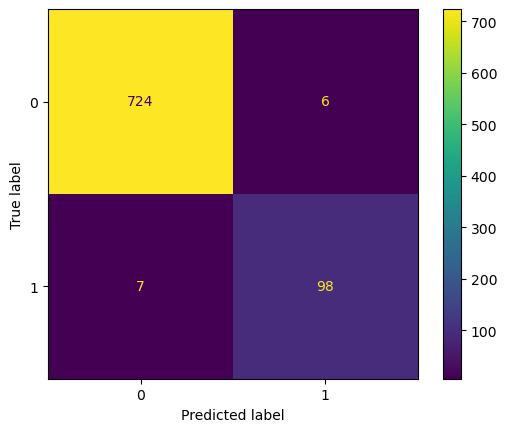

In [292]:
display_matrix_and_scores(y_true, y_pred)

In [293]:
y_true, y_pred = predictions_singleton_to_binary(model_1, 0.8, v2_pad_val, y_val)

27/27 [==============================] - 0s 3ms/step


Accuracy : 0.9844311377245509
Precision : 0.9693877551020408
Recall : 0.9047619047619048


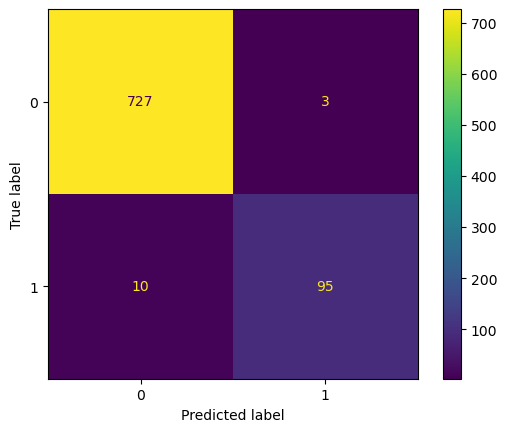

In [294]:
display_matrix_and_scores(y_true, y_pred)

In [295]:
model_2 = tf.keras.Sequential([        
                  tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[x_train.shape[1],],name="embedding"),
                  tf.keras.layers.SimpleRNN(units=64, return_sequences=True),
                  tf.keras.layers.SimpleRNN(units=32, return_sequences=False),
                  tf.keras.layers.Dense(8, activation='relu'),
                  tf.keras.layers.Dropout(0.1),
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [296]:
model_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 128)           256128    
                                                                 
 simple_rnn (SimpleRNN)      (None, 70, 64)            12352     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_45 (Dense)            (None, 8)                 264       
                                                                 
 dropout_22 (Dropout)        (None, 8)                 0         
                                                                 
 dense_46 (Dense)            (None, 1)                 9         
                                                                 
Total params: 271,857
Trainable params: 271,857
Non-t

In [297]:
model_2.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

In [298]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback_2 = hp.KerasCallback(log_dir, {
    'num_dense_units': 8,
    'num_rnn_units':96,
    'dropout_2': 0.1
})

In [299]:
model_2.fit(
    train_batch,
    epochs=20,
    verbose=1,
    callbacks=[tensorboard_callback, hparams_callback_2],
    validation_data=test_batch)

Epoch 1/20
49/49 [==============================] - 43s 805ms/step - loss: 0.6421 - accuracy: 0.8140 - precision: 0.1446 - recall: 0.0233 - val_loss: 0.5297 - val_accuracy: 0.8332 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
49/49 [==============================] - 36s 729ms/step - loss: 0.4871 - accuracy: 0.8332 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4528 - val_accuracy: 0.8332 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
49/49 [==============================] - 34s 699ms/step - loss: 0.4622 - accuracy: 0.8332 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4513 - val_accuracy: 0.8332 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
49/49 [==============================] - 33s 676ms/step - loss: 0.4626 - accuracy: 0.8332 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4516 - val_accuracy: 0.8332 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
49/49 [==========================

KeyboardInterrupt: 

In [54]:
y_true, y_pred = predictions_singleton_to_binary(model_2, 0.5, v2_pad_val, y_val)

10/10 [==============================] - 1s 36ms/step


Accuracy : 0.8795986622073578
Precision : 0.8843537414965986
Recall : 0.87248322147651


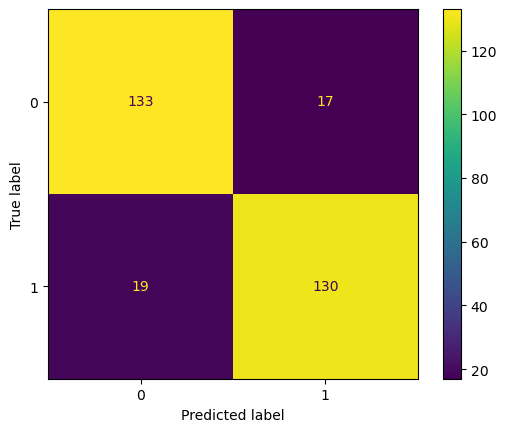

In [55]:
display_matrix_and_scores(y_true, y_pred)

In [307]:
model_3 = tf.keras.Sequential([        
                  tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[x_train.shape[1],],name="embedding"),
                  tf.keras.layers.SimpleRNN(units=64, return_sequences=True),
                  tf.keras.layers.Dropout(0.2),
                  tf.keras.layers.SimpleRNN(units=32, return_sequences=True),
                  tf.keras.layers.Dropout(0.2),
                  tf.keras.layers.SimpleRNN(units=16, return_sequences=True),
                  tf.keras.layers.GlobalAveragePooling1D(),
                  tf.keras.layers.Dropout(0.2),
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [308]:
model_3.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

In [309]:
log_dir="logs/fit/" + "model_3_3_RNN_with_global_pooling " + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback_3 = hp.KerasCallback(log_dir, {
    'num_dense_units': 8,
    'num_rnn_units':96,
    'dropout_2': 0.5
})

In [310]:
model_3.fit(
    train_batch,
    epochs=20,
    verbose=1,
    callbacks=[tensorboard_callback, hparams_callback_3],
    validation_data=test_batch)

Epoch 1/20
49/49 [==============================] - 61s 1s/step - loss: 0.2653 - accuracy: 0.9107 - precision: 0.8238 - recall: 0.5914 - val_loss: 0.1237 - val_accuracy: 0.9705 - val_precision: 0.9930 - val_recall: 0.8288
Epoch 2/20
49/49 [==============================] - 52s 1s/step - loss: 0.1214 - accuracy: 0.9724 - precision: 0.9333 - recall: 0.8988 - val_loss: 0.0923 - val_accuracy: 0.9805 - val_precision: 0.9633 - val_recall: 0.9183
Epoch 3/20
 8/49 [===>..........................] - ETA: 40s - loss: 0.0886 - accuracy: 0.9824 - precision: 0.9437 - recall: 0.9306

KeyboardInterrupt: 

In [60]:
y_true, y_pred = predictions_singleton_to_binary(model_3, 0.5, x_val, y_val)

10/10 [==============================] - 1s 53ms/step


Accuracy : 0.9230769230769231
Precision : 0.9772727272727273
Recall : 0.8657718120805369


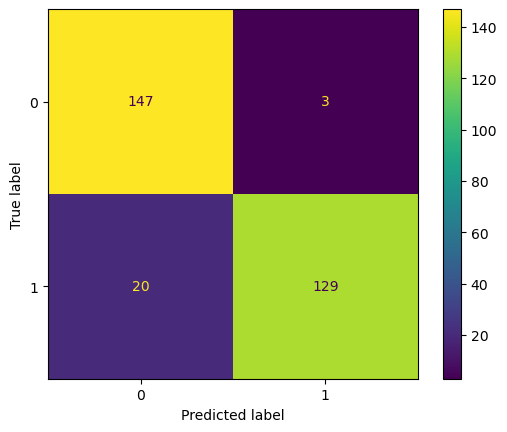

In [61]:
display_matrix_and_scores(y_true, y_pred)

In [314]:
data_val.head()

,v1,v2,v2_clean,v2_lemma,v2_tokenized
3982,ham,Nationwide auto centre (or something like that...,nationwide auto centre or something like that ...,nationwide auto centre like newport road like,"[1, 1, 1340, 15, 1, 703, 15]"
756,ham,Cant think of anyone with * spare room off * t...,cant think of anyone with spare room off top...,think spare room head,"[22, 1863, 191, 361]"
806,ham,"sure, but make sure he knows we ain't smokin yet",sure but make sure he knows we aint smokin yet,sure sure know smokin,"[99, 99, 7, 1]"
1091,ham,Please da call me any mistake from my side sor...,please da call me any mistake from my side sor...,da mistake sorry da pls da goto doctor,"[42, 782, 31, 42, 58, 42, 836, 736]"
4413,ham,How stupid to say that i challenge god.You don...,how stupid to say that i challenge godyou dont...,stupid challenge godyou think write instead re...,"[706, 1, 1, 22, 635, 1012, 863, 1]"


In [311]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/3")

In [315]:
y_train_test = preprocessor.fit_transform(data_red['v1'])
y_val = preprocessor.transform(data_val['v1'])

In [316]:
x_train, x_test, y_train, y_test = train_test_split(data_red['v2'], y_train_test, test_size=0.2, stratify=y_train_test)
x_val = data_val['v2']

In [323]:
train_batch = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(64)
test_batch = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [324]:
AUTOTUNE = tf.data.AUTOTUNE

train_batch = train_batch.cache().prefetch(buffer_size=AUTOTUNE)
val_batch = test_batch.cache().prefetch(buffer_size=AUTOTUNE)

In [325]:
for sent, targ in train_batch.take(1):
  print(sent)
  print(targ)

tf.Tensor(
[b'Delhi and chennai still silent.' b'U too...'
 b"LOL .. *grins* .. I'm not babe, but thanks for thinking of me!"
 b'What makes you most happy?'
 b'Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed \xc3\xa5\xc2\xa31000 cash or \xc3\xa5\xc2\xa35000 prize!'
 b'U WILL SWITCH YOUR FONE ON DAMMIT!!'
 b' &lt;#&gt;  mins but i had to stop somewhere first.'
 b"Love isn't a decision, it's a feeling. If we could decide who to love, then, life would be much simpler, but then less magical"
 b'You have 1 new voicemail. Please call 08719181503'
 b'Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records'
 b'DO NOT B LATE LOVE MUM'
 b'Roger that. We\xc2\x89\xc3\x9b\xc3\xb7re probably going to rem in about 20'
 b'Lol yes. But it will add some spice to your day.'
 b'todays vodafone numbers ending with 0089(my last four 

In [326]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
l = tf.keras.layers.Dropout(0.2, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(8, activation='relu')(l)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
model_4 = tf.keras.Model(inputs=[text_input], outputs = [l])

In [327]:
model_4.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [328]:
model_4.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

In [329]:
log_dir="logs/fit/" + 'model_4_bert ' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback_4 = hp.KerasCallback(log_dir, {
    'bert': 1,
    'dropout_1': 0.1
})

In [330]:
model_4.fit(
    train_batch,
    epochs=30,
    verbose=1,
    validation_data=test_batch)

Epoch 1/30


KeyboardInterrupt: 

In [95]:
y_true, y_pred = predictions_singleton_to_binary(model_4, 0.5, x_val, y_val)

10/10 [==============================] - 13s 1s/step


Accuracy : 0.9565217391304348
Precision : 0.9722222222222222
Recall : 0.9395973154362416


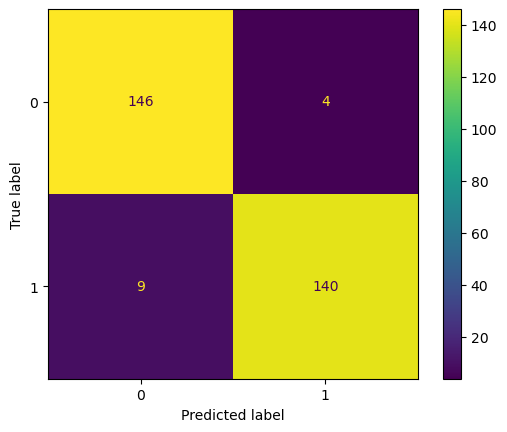

In [96]:
display_matrix_and_scores(y_true, y_pred)

In [331]:
from transformers import TFAutoModel, AutoTokenizer

In [334]:
model = TFAutoModel.from_pretrained('distilbert-base-uncased')

RuntimeError: Failed to import transformers.models.distilbert.modeling_tf_distilbert because of the following error (look up to see its traceback):
DLL load failed while importing defs: La procédure spécifiée est introuvable.